# TRAINING AND RESULTS FOR COVER SONG SIMILARITY

In [1]:
#Download needed packages
!pip install loguru
!pip install pennylane

In [9]:
#Imports
import os
import zipfile
from torch import optim
import torch
from torch import nn, optim
from tqdm import tqdm
from torch.utils.data import DataLoader
from loguru import logger
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np

In [3]:
#To reload if changes to scripts happen and you dont want to restart kernel
%load_ext autoreload
%autoreload 2

In [4]:
#Download data

!git clone https://github.com/MTG/da-tacos.git
!cd da-tacos
!python3 -m venv venv
!source venv/bin/activate
!pip install -r da-tacos/requirements.txt

# Get the current working directory
current_dir = os.getcwd()
print(f"Current directory: {current_dir}")

# Change to a new directory
new_dir = '/content/da-tacos'
os.chdir(new_dir)

# Verify the change
print(f"New current directory: {os.getcwd()}")

!python download_da-tacos.py --dataset benchmark --type hpcp
!python download_da-tacos.py --dataset benchmark --type crema
!gdown --id 17mr879NVZlB7BJS-Q0OnlWc0FfGndtIC
!gdown --id 1pVYamEvXSTSTO3YvZYFjpID0v9hNaT6H #metadata



# Define the path to your data directory
data_dir = '/content/da-tacos'

# Get a list of all .zip files in the directory
zip_files = [f for f in os.listdir(data_dir) if f.endswith('.zip')]

print(f"Found {len(zip_files)} zip files to unzip:")
for zip_file in zip_files:
    print(f"- {zip_file}")

print("\nStarting the unzipping process...")

for zip_file in zip_files:
    zip_file_path = os.path.join(data_dir, zip_file)

    # Create an output folder with the same name as the zip file (e.g., "da-tacos_metadata")
    output_folder_name = os.path.splitext(zip_file)[0]
    output_folder_path = os.path.join(data_dir, output_folder_name)

    # Ensure the output folder exists
    os.makedirs(output_folder_path, exist_ok=True)

    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        print(f"Unzipping {zip_file} into {output_folder_name}...")
        zip_ref.extractall(output_folder_path)

print("\nAll files have been unzipped successfully!")

# Change to root
new_dir = '/content'
os.chdir(new_dir)

# Verify the change
print(f"New current directory: {os.getcwd()}")

Cloning into 'da-tacos'...
remote: Enumerating objects: 112, done.
remote: Counting objects: 100% (7/7), done.
remote: Total 112 (delta 6), reused 6 (delta 6), pack-reused 105 (from 1)
Receiving objects: 100% (112/112), 29.62 KiB | 7.40 MiB/s, done.
Resolving deltas: 100% (50/50), done.
Error: Command '['/content/venv/bin/python3', '-m', 'ensurepip', '--upgrade', '--default-pip']' returned non-zero exit status 1.
/bin/bash: line 1: venv/bin/activate: No such file or directory
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=9d2cebd1e3d5e2d4b0455b5d3c9282b88a0b1def32f0cf733e8aab014d6e27fe
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget
Current directory: /content
New current directory: /content/da-tacos
Downloading...
From (original): https://drive.google.com/uc?id=1B6ZEPRmuqLgcVk4-l5NvZoL2Sg5Nh-49
From (redirected): https://drive.googl

In [1]:
import sys, pathlib
sys.path.insert(0, str(pathlib.Path.cwd() / "src"))

In [2]:

#Imports to create a dataset with num_total_pairs
#Generate data pairs
from dataset import CoverSongDataset, GeneratePairs, create_dataloaders
num_total_pairs = 1000
pairs = GeneratePairs(num_total_pairs).generate_pairs()
print(f"Generated {len(pairs)} pairs of songs.")
print(f"Five pairs: {pairs[:5]}")


Generated 1000 pairs of songs.
Five pairs: [('W_399', 'P_781868', 'W_118399', 'P_599444', 1), ('W_546', 'P_235707', 'W_546', 'P_250764', 0), ('W_1650', 'P_458011', 'W_1650', 'P_1828', 0), ('W_1456', 'P_384242', 'W_1456', 'P_106678', 0), ('W_30678', 'P_30678', 'W_30678', 'P_91508', 0)]


In [3]:
#example datapoint
from dataset import CoverSongDataset
features = ['crema']  # feature names
data = CoverSongDataset(pairs, features, max_frames=4000)  # Create dataset with pairs and features
f_a, f_b, label =data[0]  # Get the first item in the dataset
(f_a.shape, f_b.shape, label)  # Print the shapes of the features and label

(torch.Size([4000, 12]), torch.Size([4000, 12]), tensor(1.))

## Training

In [4]:
from models import SiameseNetQuantum
from train import train_siamese_network, test_siamese_network
from losses import SimilarityLoss#, ContrastiveLoss

In [5]:
#Create training, validation and test data for training
features = [ 'hpcp', 'crema']  # Example feature names
pairs = GeneratePairs(5000).generate_pairs()
data = CoverSongDataset(pairs, features, conv1d=True, max_frames=2000)  # Create dataset with pairs
loaders = create_dataloaders(data, batch_size=32, validation_split=0.2, test_split=0.2)

1000 1000 3000 5000
94


In [6]:
#loss
criterion = SimilarityLoss()

In [27]:
#Classical
modelQuantum_classical = SiameseNetQuantum(input_dims=24, embedding_size=128, n_qubits=7, n_layers=1, use_quantum= False)
optimizer = optim.Adam(modelQuantum_classical.parameters(), lr=5e-4)#1e-3
logger.info("Training the model starts..")
model_c, data_c =train_siamese_network(loaders, modelQuantum_classical, criterion, optimizer, num_epochs=20)
torch.save(data_c, 'data_classical.pt')
torch.save(model_c.state_dict(), './model_classical_last.pth')

2025-08-14 21:01:33.514 | INFO     | __main__:<cell line: 0>:4 - Training the model starts..
2025-08-14 21:01:33.530 | INFO     | train:train_siamese_network:23 - Starting training of Siamese network...
100%|██████████| 94/94 [02:41<00:00,  1.72s/it]
2025-08-14 21:04:15.121 | INFO     | train:train_siamese_network:62 - Epoch [1/20], Loss: 0.7121, Train Accuracy: 0.4973
100%|██████████| 32/32 [00:29<00:00,  1.09it/s]
2025-08-14 21:04:44.452 | INFO     | train:evaluate_siamese_network:121 - Evaluation Loss: 0.6922, Accuracy: 0.5190
2025-08-14 21:04:44.454 | INFO     | train:train_siamese_network:69 - Validation Loss: 0.6922, Validation Accuracy: 0.5190


Saved the best model with validation accuracy: 0.52%


100%|██████████| 94/94 [02:21<00:00,  1.51s/it]
2025-08-14 21:07:06.229 | INFO     | train:train_siamese_network:62 - Epoch [2/20], Loss: 0.6905, Train Accuracy: 0.5320
100%|██████████| 32/32 [00:28<00:00,  1.11it/s]
2025-08-14 21:07:35.147 | INFO     | train:evaluate_siamese_network:121 - Evaluation Loss: 0.6819, Accuracy: 0.5190
2025-08-14 21:07:35.148 | INFO     | train:train_siamese_network:69 - Validation Loss: 0.6819, Validation Accuracy: 0.5190
100%|██████████| 94/94 [02:25<00:00,  1.55s/it]
2025-08-14 21:10:00.576 | INFO     | train:train_siamese_network:62 - Epoch [3/20], Loss: 0.6621, Train Accuracy: 0.5987
100%|██████████| 32/32 [00:30<00:00,  1.04it/s]
2025-08-14 21:10:31.277 | INFO     | train:evaluate_siamese_network:121 - Evaluation Loss: 0.6694, Accuracy: 0.5190
2025-08-14 21:10:31.287 | INFO     | train:train_siamese_network:69 - Validation Loss: 0.6694, Validation Accuracy: 0.5190
100%|██████████| 94/94 [02:28<00:00,  1.58s/it]
2025-08-14 21:12:59.968 | INFO     | tra

Saved the best model with validation accuracy: 0.63%


100%|██████████| 94/94 [02:25<00:00,  1.55s/it]
2025-08-14 21:18:46.799 | INFO     | train:train_siamese_network:62 - Epoch [6/20], Loss: 0.6199, Train Accuracy: 0.6510
100%|██████████| 32/32 [00:28<00:00,  1.11it/s]
2025-08-14 21:19:15.560 | INFO     | train:evaluate_siamese_network:121 - Evaluation Loss: 0.6874, Accuracy: 0.5890
2025-08-14 21:19:15.562 | INFO     | train:train_siamese_network:69 - Validation Loss: 0.6874, Validation Accuracy: 0.5890
100%|██████████| 94/94 [02:28<00:00,  1.58s/it]
2025-08-14 21:21:43.911 | INFO     | train:train_siamese_network:62 - Epoch [7/20], Loss: 0.6006, Train Accuracy: 0.6767
100%|██████████| 32/32 [00:33<00:00,  1.04s/it]
2025-08-14 21:22:17.229 | INFO     | train:evaluate_siamese_network:121 - Evaluation Loss: 0.6926, Accuracy: 0.5180
2025-08-14 21:22:17.230 | INFO     | train:train_siamese_network:69 - Validation Loss: 0.6926, Validation Accuracy: 0.5180
100%|██████████| 94/94 [02:23<00:00,  1.53s/it]
2025-08-14 21:24:41.019 | INFO     | tra

Saved the best model with validation accuracy: 0.63%


100%|██████████| 94/94 [02:22<00:00,  1.52s/it]
2025-08-14 21:30:24.762 | INFO     | train:train_siamese_network:62 - Epoch [10/20], Loss: 0.5844, Train Accuracy: 0.6840
100%|██████████| 32/32 [00:33<00:00,  1.04s/it]
2025-08-14 21:30:57.989 | INFO     | train:evaluate_siamese_network:121 - Evaluation Loss: 0.6811, Accuracy: 0.5940
2025-08-14 21:30:57.990 | INFO     | train:train_siamese_network:69 - Validation Loss: 0.6811, Validation Accuracy: 0.5940
100%|██████████| 94/94 [02:18<00:00,  1.48s/it]
2025-08-14 21:33:16.825 | INFO     | train:train_siamese_network:62 - Epoch [11/20], Loss: 0.5692, Train Accuracy: 0.6970
100%|██████████| 32/32 [00:28<00:00,  1.14it/s]
2025-08-14 21:33:44.904 | INFO     | train:evaluate_siamese_network:121 - Evaluation Loss: 0.6867, Accuracy: 0.5510
2025-08-14 21:33:44.906 | INFO     | train:train_siamese_network:69 - Validation Loss: 0.6867, Validation Accuracy: 0.5510
100%|██████████| 94/94 [02:19<00:00,  1.49s/it]
2025-08-14 21:36:04.893 | INFO     | t

In [15]:
#Quantum
modelQuantum = SiameseNetQuantum(input_dims=24, embedding_size=128, n_qubits=7, n_layers=2, use_quantum= True)
optimizer = optim.Adam(modelQuantum.parameters(), lr=5e-4)
logger.info("Training the model with quantum layer starts..")
model_q, data_q =train_siamese_network(loaders, modelQuantum, criterion, optimizer, num_epochs=20)
torch.save(data_q, 'data_quantum.pt')
torch.save(model_q.state_dict(), './model_quantum_last.pth')

2025-08-14 19:47:42.063 | INFO     | __main__:<cell line: 0>:4 - Training the model with quantum layer starts..
2025-08-14 19:47:42.095 | INFO     | train:train_siamese_network:23 - Starting training of Siamese network...
100%|██████████| 94/94 [02:36<00:00,  1.66s/it]
2025-08-14 19:50:18.573 | INFO     | train:train_siamese_network:62 - Epoch [1/20], Loss: 0.6931, Train Accuracy: 0.5083
100%|██████████| 32/32 [00:30<00:00,  1.04it/s]
2025-08-14 19:50:49.378 | INFO     | train:evaluate_siamese_network:121 - Evaluation Loss: 0.6935, Accuracy: 0.4810
2025-08-14 19:50:49.380 | INFO     | train:train_siamese_network:69 - Validation Loss: 0.6935, Validation Accuracy: 0.4810


Saved the best model with validation accuracy: 0.48%


100%|██████████| 94/94 [02:39<00:00,  1.70s/it]
2025-08-14 19:53:28.886 | INFO     | train:train_siamese_network:62 - Epoch [2/20], Loss: 0.6931, Train Accuracy: 0.5090
100%|██████████| 32/32 [00:30<00:00,  1.07it/s]
2025-08-14 19:53:58.919 | INFO     | train:evaluate_siamese_network:121 - Evaluation Loss: 0.6935, Accuracy: 0.4810
2025-08-14 19:53:58.920 | INFO     | train:train_siamese_network:69 - Validation Loss: 0.6935, Validation Accuracy: 0.4810
100%|██████████| 94/94 [02:32<00:00,  1.62s/it]
2025-08-14 19:56:31.034 | INFO     | train:train_siamese_network:62 - Epoch [3/20], Loss: 0.6931, Train Accuracy: 0.5090
100%|██████████| 32/32 [00:30<00:00,  1.06it/s]
2025-08-14 19:57:01.143 | INFO     | train:evaluate_siamese_network:121 - Evaluation Loss: 0.6936, Accuracy: 0.4810
2025-08-14 19:57:01.144 | INFO     | train:train_siamese_network:69 - Validation Loss: 0.6936, Validation Accuracy: 0.4810
100%|██████████| 94/94 [02:33<00:00,  1.63s/it]
2025-08-14 19:59:34.168 | INFO     | tra

Saved the best model with validation accuracy: 0.62%


100%|██████████| 94/94 [02:34<00:00,  1.65s/it]
2025-08-14 20:02:38.773 | INFO     | train:train_siamese_network:62 - Epoch [5/20], Loss: 0.6931, Train Accuracy: 0.5183
100%|██████████| 32/32 [00:30<00:00,  1.06it/s]
2025-08-14 20:03:09.072 | INFO     | train:evaluate_siamese_network:121 - Evaluation Loss: 0.6859, Accuracy: 0.6040
2025-08-14 20:03:09.073 | INFO     | train:train_siamese_network:69 - Validation Loss: 0.6859, Validation Accuracy: 0.6040
100%|██████████| 94/94 [02:31<00:00,  1.61s/it]
2025-08-14 20:05:40.191 | INFO     | train:train_siamese_network:62 - Epoch [6/20], Loss: 0.6703, Train Accuracy: 0.6107
100%|██████████| 32/32 [00:30<00:00,  1.05it/s]
2025-08-14 20:06:10.760 | INFO     | train:evaluate_siamese_network:121 - Evaluation Loss: 0.6613, Accuracy: 0.6070
2025-08-14 20:06:10.761 | INFO     | train:train_siamese_network:69 - Validation Loss: 0.6613, Validation Accuracy: 0.6070
100%|██████████| 94/94 [02:33<00:00,  1.64s/it]
2025-08-14 20:08:44.484 | INFO     | tra

Saved the best model with validation accuracy: 0.65%


100%|██████████| 94/94 [02:32<00:00,  1.62s/it]
2025-08-14 20:15:10.505 | INFO     | train:train_siamese_network:62 - Epoch [9/20], Loss: 0.6248, Train Accuracy: 0.6683
100%|██████████| 32/32 [00:31<00:00,  1.02it/s]
2025-08-14 20:15:41.805 | INFO     | train:evaluate_siamese_network:121 - Evaluation Loss: 0.6338, Accuracy: 0.6460
2025-08-14 20:15:41.807 | INFO     | train:train_siamese_network:69 - Validation Loss: 0.6338, Validation Accuracy: 0.6460
100%|██████████| 94/94 [02:30<00:00,  1.60s/it]
2025-08-14 20:18:12.232 | INFO     | train:train_siamese_network:62 - Epoch [10/20], Loss: 0.6121, Train Accuracy: 0.6737
100%|██████████| 32/32 [00:30<00:00,  1.05it/s]
2025-08-14 20:18:42.744 | INFO     | train:evaluate_siamese_network:121 - Evaluation Loss: 0.6109, Accuracy: 0.6890
2025-08-14 20:18:42.747 | INFO     | train:train_siamese_network:69 - Validation Loss: 0.6109, Validation Accuracy: 0.6890


Saved the best model with validation accuracy: 0.69%


100%|██████████| 94/94 [02:41<00:00,  1.71s/it]
2025-08-14 20:21:23.929 | INFO     | train:train_siamese_network:62 - Epoch [11/20], Loss: 0.6031, Train Accuracy: 0.6937
100%|██████████| 32/32 [00:30<00:00,  1.05it/s]
2025-08-14 20:21:54.398 | INFO     | train:evaluate_siamese_network:121 - Evaluation Loss: 0.6216, Accuracy: 0.6490
2025-08-14 20:21:54.400 | INFO     | train:train_siamese_network:69 - Validation Loss: 0.6216, Validation Accuracy: 0.6490
100%|██████████| 94/94 [02:31<00:00,  1.61s/it]
2025-08-14 20:24:25.547 | INFO     | train:train_siamese_network:62 - Epoch [12/20], Loss: 0.5990, Train Accuracy: 0.6947
100%|██████████| 32/32 [00:29<00:00,  1.09it/s]
2025-08-14 20:24:55.029 | INFO     | train:evaluate_siamese_network:121 - Evaluation Loss: 0.6253, Accuracy: 0.6490
2025-08-14 20:24:55.032 | INFO     | train:train_siamese_network:69 - Validation Loss: 0.6253, Validation Accuracy: 0.6490
100%|██████████| 94/94 [02:30<00:00,  1.60s/it]
2025-08-14 20:27:25.599 | INFO     | t

## Plots

In [7]:
from utils import plot_loss, roc_c

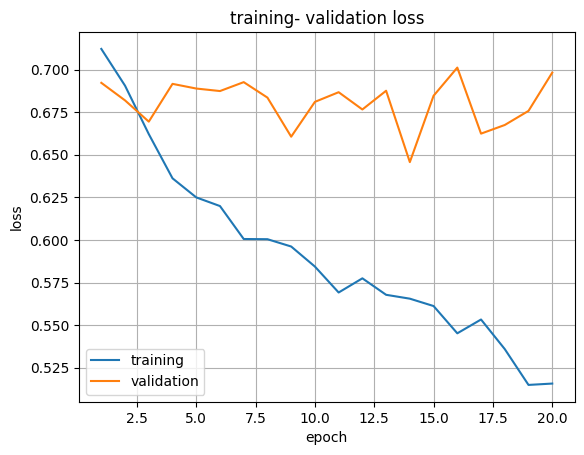

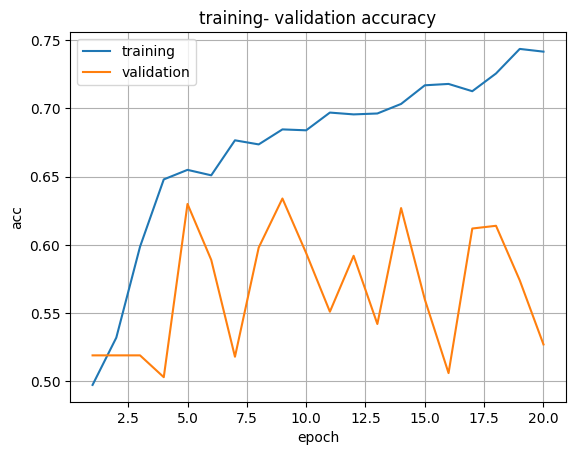

In [28]:
epochs = data_c["epochs"]
loss_train = data_c["loss_history"]
loss_val=data_c["val_loss_history"]
acc_train=data_c['train_accuracy_history']
acc_val=data_c["val_accuracy_history"]
plot_loss(epochs, [loss_train, loss_val])
plot_loss(epochs, [acc_train, acc_val], title='training- validation accuracy', ylabel='acc')

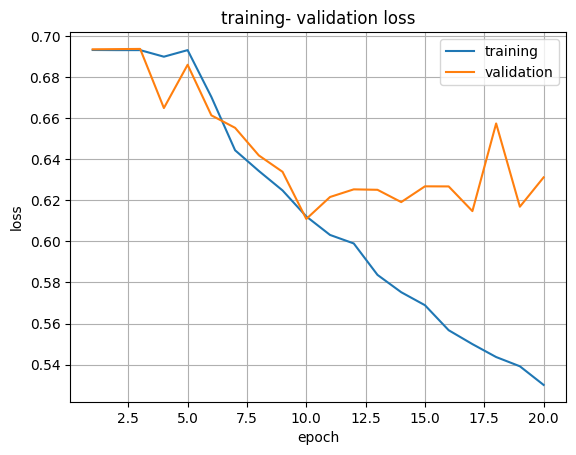

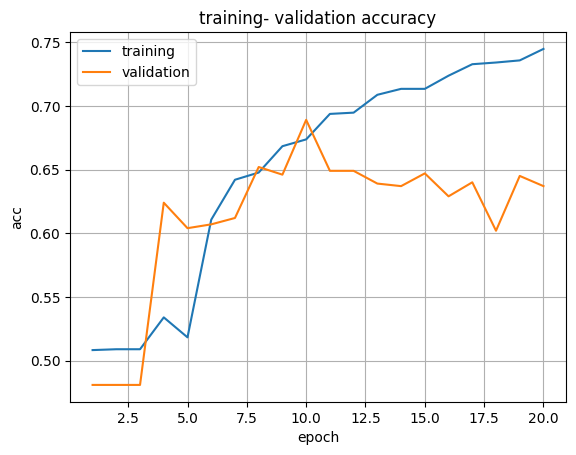

In [21]:
epochs = data_q["epochs"]
loss_train = data_q["loss_history"]
loss_val=data_q["val_loss_history"]
acc_train=data_q['train_accuracy_history']
acc_val=data_q["val_accuracy_history"]
plot_loss(epochs, [loss_train, loss_val])
plot_loss(epochs, [acc_train, acc_val], title='training- validation accuracy', ylabel='acc')

100%|██████████| 32/32 [00:55<00:00,  1.73s/it]
2025-08-15 02:53:19.699 | INFO     | train:test_siamese_network:170 - Evaluation Loss: 0.6405, Accuracy: 0.6270


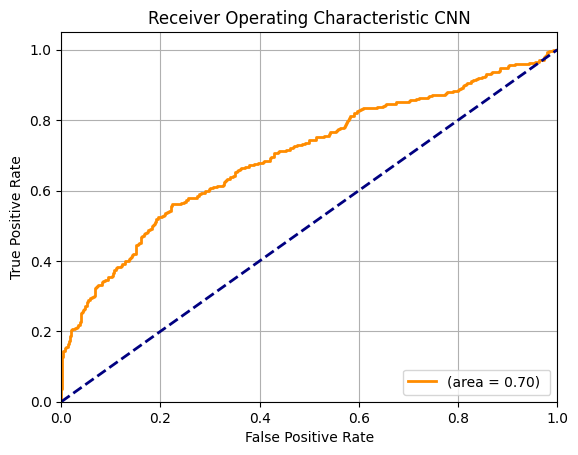

In [10]:
#Classical
modelQuantum_best_cl = SiameseNetQuantum(input_dims=24, embedding_size=128, n_qubits=7, n_layers=2, use_quantum= False)
state = torch.load("./models/best_model_c.pth")
modelQuantum_best_cl.load_state_dict(state, strict=False)  # use strict=True if architectures match exactly
true, pred = test_siamese_network(modelQuantum_best_cl, loaders["test"], criterion)
roc_c(true, pred)


  0%|          | 0/32 [00:00<?, ?it/s]

100%|██████████| 32/32 [00:49<00:00,  1.56s/it]
2025-08-15 02:54:58.659 | INFO     | train:test_siamese_network:170 - Evaluation Loss: 0.6282, Accuracy: 0.6570


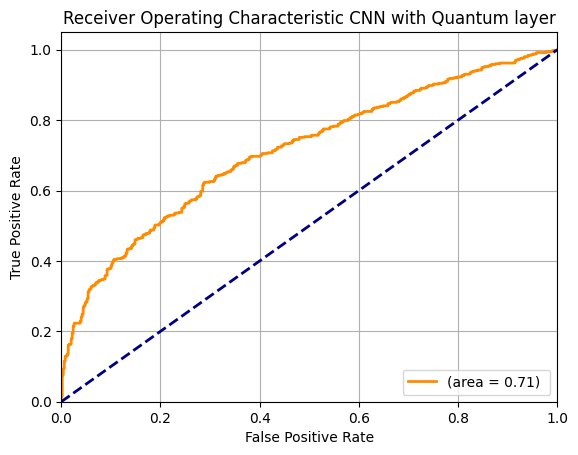

In [12]:
#Quantum
modelQuantum_best_q = SiameseNetQuantum(input_dims=24, embedding_size=128, n_qubits=7, n_layers=2, use_quantum= True)
state = torch.load("./models/best_model_quantum.pth")
modelQuantum_best_q.load_state_dict(state, strict=False)  # use strict=True if architectures match exactly
true, pred = test_siamese_network(modelQuantum_best_q, loaders["test"], criterion)
roc_c(true, pred, 'CNN with Quantum layer')